In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader            

In [4]:
# from dataset import Fingers

import glob
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class Fingers(Dataset):

    # define constructor
    def __init__(self, directory, transform=None):
        '''
        Arguments:
        + directory (string): Directory containing image data
        + transform (callable): optional transform to apply on sample
        '''
        # directory containing the images
        self.directory = directory
        self.transform = transform
        self.glob_path = glob.glob(directory)
        self.dataset = []
        self.class_set = []
        # Images follow the pattern of <some random string>_<class>.png, we parse through the string name to extract the number of fingers in the photo.
        for img_path in self.glob_path:
            self.dataset.append(img_path)
            self.class_set.append(int(img_path[-6:-5]))
        # dataset contains paths of all the iamges
        self.dataset = np.array(self.dataset)
        

    def __len__(self):
        # length of list
        return len(self.dataset)

    def __getitem__(self, idx):
        image = read_image(self.dataset[idx], ImageReadMode.UNCHANGED).float()
        label = self.class_set[idx]

        # return image and label
        return(image, label)

In [10]:
# from model import ConvNet

import torch.nn.functional as F

class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            # Convolutional layers
            # Images are all in grayscale so only 1 colour channel
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=1)
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1)
            self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1)
            self.pool = nn.MaxPool2d(2,2)
            # Fully Connected Layers
            self.fc1 = nn.Linear(128*13*13, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 6)


        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            
            # Flattening the tensor dimensions after convolutions
            x = x.view(-1, 128*13*13)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

In [11]:
def imshow(sample_element):
    plt.imshow(sample_element[0].numpy().reshape((128, 128)), cmap='gray')
    plt.show()

In [12]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
batch_s = 36 # Determines how many times the model steps through (2000, 1000, 500)
n_classes = 6 # Model classifications (number of fingers)
learning_rate = 0.0001 # Determines how much the model changes during training
n_epochs = 1 # Determines how many times the training process loops

preprocess = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

Epoch [1/1], Step [100/500], Loss: 0.6287
Epoch [1/1], Step [200/500], Loss: 0.2836
Epoch [1/1], Step [300/500], Loss: 0.1565
Epoch [1/1], Step [400/500], Loss: 0.1797
Epoch [1/1], Step [500/500], Loss: 0.0884
Finished Training! 

Network with learning rate of 0.0001 over 1 epochs results in accuracy of: 97.75 %
Accuracy of 0 fingers: 100.0 %
Accuracy of 1 fingers: 97.5 %
Accuracy of 2 fingers: 96.83333333333333 %
Accuracy of 3 fingers: 92.66666666666667 %
Accuracy of 4 fingers: 99.83333333333333 %
Accuracy of 5 fingers: 99.66666666666667 %


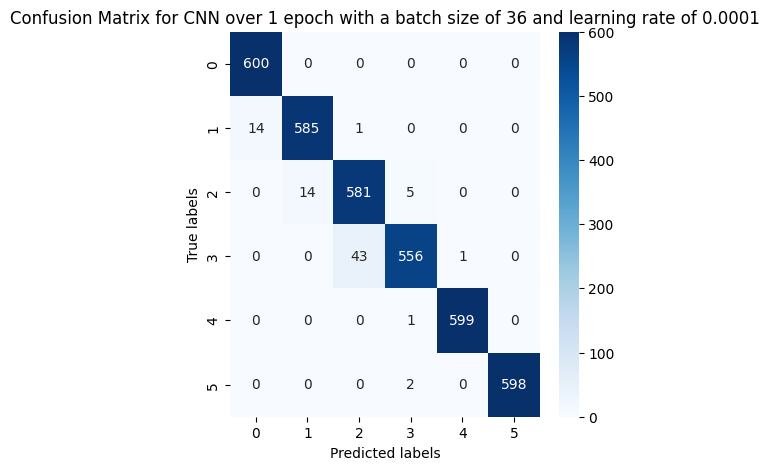

In [13]:
# Fingers dataset consists of 21600 128x128 black & white images of left/right hands
# Each image then providing a 1x128x128 dimensional tensor

# Training set consists of 18,000 images
train_dataset = Fingers('./data/train/*.png', transform=preprocess)
# Test set consists of 2,600 images
test_dataset = Fingers('./data/test/*.png', transform=preprocess)

train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)
                
classes = ('0', '1', '2', '3', '4', '5')

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass and optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if (i+1) % 100 == 0:
                        print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

print('Finished Training! \n')  

# Tracking preds and labels
all_predictions = []
all_labels = []

with torch.no_grad(): # Don't need backward propagation and gradient calculations
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_s):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
confusion_m = confusion_matrix(all_labels, all_predictions)

accuracy = 100.0 * n_correct / n_samples
print(f'Network with learning rate of {learning_rate} over {n_epochs} epochs results in accuracy of: {accuracy} %')
                    
for i in range(n_classes):
    if n_class_samples[i] != 0:
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
    else:
        accuracy = 'NaN'

    print(f'Accuracy of {classes[i]} fingers: {accuracy} %')

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_m, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for CNN over {n_epochs} epoch with a batch size of {batch_s} and learning rate of {learning_rate}')
plt.show()